# Experiments With Network Growing on CIFAR-100

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import cv2
import random
from itertools import chain
from imgaug import augmenters as iaa #augmentation module from https://github.com/aleju/imgaug

c:\users\vivia\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Dataset Handeling

In [2]:
class CIFAR():
    def __init__(self, directory = "./"):
        self._directory = directory
        
        self._training_data = []
        self._training_labels = []
        self._test_data = []
        self._test_labels = []
        
        self._load_traing_data()
        self._load_test_data()
        
        np.random.seed(0)
        
        samples_n = self._training_labels.shape[0]
        random_indices = np.random.choice(samples_n, samples_n // 10, replace = False)
        np.random.seed()
        
        self._validation_data = self._training_data[random_indices]
        self._validation_labels = self._training_labels[random_indices]
        self._training_data = np.delete(self._training_data, random_indices, axis = 0)
        self._training_labels = np.delete(self._training_labels, random_indices)
        
    
    def _load_traing_data(self):
        path = os.path.join(self._directory, "train")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            #print(cifar_data)
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            imgs = imgs.transpose([0, 2, 3, 1])
            self._training_data = imgs
            self._training_labels = np.array(cifar_data[b"fine_labels"])
    
    def _load_test_data(self):
        path = os.path.join(self._directory, "test")
        with open(path, 'rb') as fd:
            cifar_data = pickle.load(fd, encoding = "bytes")
            imgs = cifar_data[b"data"].reshape([-1, 3, 32, 32])
            self._test_data = imgs.transpose([0, 2, 3, 1])
            self._test_labels = np.array(cifar_data[b"fine_labels"])
    
    def get_training_batch(self, batch_size, numC,balanced=True):
        if balanced:
            return self._get_batch(self._training_data[np.where(self._training_labels<=numC)], self._training_labels[np.where(self._training_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._training_data[np.where(self._training_labels==numC)], self._training_labels[np.where(self._training_labels==numC)], batch_size)
    def get_validation_batch(self, batch_size, numC,balanced=True):
        if balanced:
            return self._get_batch(self._validation_data[np.where(self._validation_labels<=numC)], self._validation_labels[np.where(self._validation_labels<=numC)], batch_size)
        else:
            return self._get_batch(self._validation_data[np.where(self._validation_labels==numC)], self._validation_labels[np.where(self._validation_labels==numC)], batch_size)
        
            
    def get_test_batch(self, batch_size):
        return self._get_batch(self._test_data, self._test_labels, batch_size)
    
    def _get_batch(self, data, labels, batch_size):
        samples_n = labels.shape[0]
        if batch_size <= 0:
            batch_size = samples_n
        
        random_indices = np.random.choice(samples_n, samples_n, replace = False)
        data = data[random_indices]
        labels = labels[random_indices]
        for i in range(samples_n // batch_size):
            on = i * batch_size
            off = on + batch_size
            yield data[on:off], labels[on:off]
    
    
    def get_sizes(self):
        training_samples_n = self._training_labels.shape[0]
        validation_samples_n = self._validation_labels.shape[0]
        test_samples_n = self._test_labels.shape[0]
        return training_samples_n, validation_samples_n, test_samples_n
    
    

In [3]:
#path = "C:/Vivi's Dateien/Dropbox/"
path = "C:/Users/vivia/Dropbox/"
#path = "/Users/ingen/Dropbox/"
cifar = CIFAR(path + "Master Thesis/code/cifar-100-python")

#### Add Option to Have New Class Overrepresented

In [4]:
def GetUnbalancedData(NumC,batchSize):
    #images, labels = next(cifar.get_training_batch(batchSize,NumC,balanced=True))
    #newI, newL = next(cifar.get_training_batch(batchSize,NumC,balanced=False))
    #return np.append(images,newI,axis=0),np.append(labels, newL,axis=0)
    return cifar.get_training_batch(batchSize,NumC,balanced=False)#chain(cifar.get_training_batch(batchSize,NumC,balanced=True),cifar.get_training_batch(batchSize,NumC,balanced=False))

#### Augment The Dataset

In [5]:
def augment(images):
    """newImages = []
    for i in images:
        rand = random.randint(1,10)
        if rand<=2:#keep image how it is
            newImages.append(i)
        elif rand<=4:#horizontally flip image
            newImages.append(np.fliplr(i))
        elif rand<=6:
            print(cv2.randn(i,(0),(1)))
            newImages.append(cv2.randn(i,(0),(99)))
        else:
            newImages.append(i)"""    
    seq = iaa.Sometimes(0.7,iaa.SomeOf(2,[#apply to 70% of the images two of these transformations
          iaa.Crop(px=(0, 1)), # crop images from each side by 0 to 16px (randomly chosen)
          iaa.Fliplr(0.5), # horizontally flip 50% of the images
          iaa.GaussianBlur(sigma=(0, 1.0)), # blur images with a sigma of 0 to 1.0
          iaa.CropAndPad(percent=(-0.25, 0.25)),#crop some part of the image and replace with black
        #iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),#change colorspace
        iaa.Sharpen(alpha=(0.0, 1.0), lightness=(0.75, 2.0)),#sharpen
        iaa.Add((-40, 40)),#add value between -40 and 40 to each pixel
        iaa.CoarseDropout((0.0, 0.05), size_percent=(0.02, 0.25)),#drop out random pixel patches
        iaa.Affine(rotate=(-45, 45))#rotate image slightly
    ]))
    images_aug = seq.augment_images(images)
    return images_aug#np.array(newImages)

#### Example Batch (Top: Normal, Bottom: Augmented)

<Figure size 3600x1440 with 0 Axes>

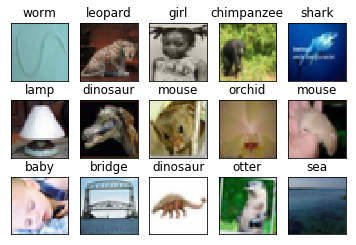

<Figure size 3600x1440 with 0 Axes>

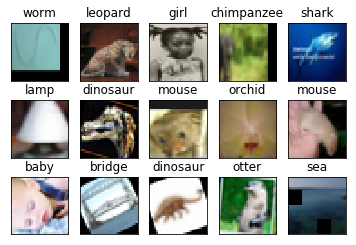

In [13]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]
images, labels = next(cifar.get_training_batch(15,99,balanced=True))
#images, labels = next(GetUnbalancedData(80,15))
plt.figure(figsize=(50,20))
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(CIFAR100_LABELS_LIST[labels[i]])
images = augment(images)

plt.figure(figsize=(50,20))
fig, axs = plt.subplots(3, 5)
for i, ax in enumerate(np.reshape(axs, [-1])):
    ax.imshow(images[i])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(CIFAR100_LABELS_LIST[labels[i]])
#plt.show()
#plt.savefig('Results/CIFAR-100-aug-balance')

### Helper Functions

In [8]:
def printAll(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
        print(v.name)
def getNames(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v.name)
    return lst_vars
def getTensors(globalVar):
    lst_vars = []
    for v in globalVar:
        lst_vars.append(v)
    return lst_vars
def getUnititialized(allVars):
    uninitialized_vars = []
    for var in allVars:
        try:
            session.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)
    return uninitialized_vars
def getSubSet(toFreeze,All):
    for var in toFreeze:
        All.remove(var)
    return All
def OwnAccuracyCalculator(out,target,maxOld):
    numRight = 0
    RightNew = 0
    RightOld = 0
    WrongNew = 0
    WrongOld = 0
    for i,e in enumerate(out):
        label = np.argmax(e)       
        if target[i]<maxOld:         
            if label==target[i]:
                numRight = numRight+1
                RightOld = RightOld+1
            else:
                WrongOld = WrongOld+1
        else:
            if label==target[i]:
                numRight = numRight+1
                RightNew = RightNew+1
            else:
                WrongNew = WrongNew+1            
    AccAll = numRight/out.shape[0]
    AccOld = RightOld/(RightOld+WrongOld)
    try:
        AccNew = RightNew/(RightNew+WrongNew)
    except:
        AccNew = 0
        #print("numOld = "+str(WrongOld+RightOld))
    return AccAll,AccOld,AccNew
def smoothListGaussian(list,strippedXs=False,degree=5):  
    #Code from https://www.swharden.com/wp/2008-11-17-linear-data-smoothing-in-python/
    window=degree*2-1  
    weight=np.array([1.0]*window)  
    weightGauss=[]  
    for i in range(window):  
        i=i-degree+1  
        frac=i/float(window)  
        gauss=1/(np.exp((4*(frac))**2))  
        weightGauss.append(gauss)
    weight=np.array(weightGauss)*weight  
    smoothed=[0.0]*(len(list)-window)  
    for i in range(len(smoothed)):
        smoothed[i]=sum(np.array(list[i:i+window])*weight)/sum(weight)  
    return smoothed
def perfQuantifier(accs,esteps,smooth=True,useVal=False):
    if smooth:
        smoothacc = smoothListGaussian(accs,degree=20)
    else:
        smoothacc = accs
    numEpochs = esteps.shape[0]
    plateauStart = np.zeros((esteps.shape[0]-1))
    pleateau = np.zeros((esteps.shape[0]-1))
    mins = np.zeros((esteps.shape[0]-1))
    for i in range(numEpochs-1):
        part = np.array(smoothacc[esteps[i]:esteps[i+1]])
        tenpermax = max(part[np.nonzero(part)])-0.02#plateau starts when max-2% is reached
        #max(part)-(max(part)-min(part))/4#get threshold of 10% below maximum
        pleateau[i] = tenpermax
        plateauStart[i] = np.where(part>=tenpermax)[0][0]
        mins[i] = np.min(part[np.nonzero(part)])
    return plateauStart,pleateau,mins
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z))).T
    return sm
#Plotting -------------------------------------------------------------------------------------------------------------
def plotPerformance(training_accuracies,validation_accuracies,steps,title,useVal=False):
    fig = plt.figure(figsize=(20,15))
    grid = plt.GridSpec(3,2,hspace=0.4, wspace=0.4)
    fig.add_subplot(grid[:2,:])
    plt.plot(training_accuracies)
    if useVal:
        plt.plot(np.nonzero(validation_accuracies)[0],validation_accuracies[np.nonzero(validation_accuracies)],linewidth=5)
    else:
        plt.plot(np.append(validation_accuracies,validation_accuracies[-1]), linewidth=5)
    plt.plot(np.full(steps[-1],0.5), linewidth=5, color = 'black')
    plt.xlabel("Training Step", fontsize=18)
    plt.ylabel("Accuracy in %", fontsize=18)
    plt.title(title, fontsize=18)
    plt.xlim(0,steps[-1]-100)
    plt.legend(['training','validation','CIFAR-10'],fontsize=20,loc=3)
    if useVal:
        start,v,mini = perfQuantifier(validation_accuracies,steps,useVal=True,smooth=False)
    else:
        start,v,mini = perfQuantifier(training_accuracies,steps)
    for s in steps:
        plt.axvline(x=s,color='r')
    for i in range(steps.shape[0]-1):
        plt.plot(np.linspace(steps[i],steps[i+1],steps[i+1]-steps[i]),np.full(steps[i+1]-steps[i],v[i]), linewidth=2, color = 'green')
        plt.axvline(x=steps[i]+start[i],color='green')
    plt.scatter(steps[:-1],mini,color='r')

    fig.add_subplot(grid[2,0])
    plt.bar(np.linspace(0,start.shape[0]-1
                        ,start.shape[0]),start)
    plt.title("Steps until Convergance in Reached (Max-2%)", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Number of Steps", fontsize=18)
    plt.xticks(np.linspace(0,start.shape[0]-1,start.shape[0]), np.linspace(0,start.shape[0]-1,start.shape[0])) 
    fig.add_subplot(grid[2,1])
    plt.bar(np.linspace(0,mini.shape[0]-1,mini.shape[0]),mini)
    plt.ylim(0,1)
    plt.title("Minimum Performance in this Training Cycle", fontsize=18)
    plt.xlabel("Number of Reinitialization", fontsize=18)
    plt.ylabel("Performance in %", fontsize=18)
    plt.xticks(np.linspace(0,mini.shape[0]-1,mini.shape[0]), np.linspace(0,mini.shape[0]-1,mini.shape[0]))

def createNodeImg(NIn,NOut):
    AllOut = []
    for i in range(NOut):
        node = np.full(NIn,i)
        AllOut = np.append(AllOut,node)
    return AllOut
def plotWeights(weights,NIn,NOut):
    nodeRef = createNodeImg(NIn,NOut)
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(weights.reshape((NIn*NOut)//(NOut*8),NOut*8),vmin=-0.05,vmax=0.05)
    ax.set_title("Weights for "+str(NOut)+" Output Nodes")
    plt.colorbar()
    ax2 = fig.add_subplot(1, 2, 2)
    plt.imshow(nodeRef.reshape((NIn*NOut)//(NOut*8),NOut*8))
    ax2.set_title("Reference for Nodes")
def plotOutDist(vlabels,out):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.hist(vlabels,bins=out.shape[1])
    plt.title("Label Distribution")
    plt.subplot(1,2,2)
    plt.hist(np.argmax(out,axis=1),bins=out.shape[1])
    plt.title("Output Distribution")
def plotViolinWeights(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    fig = plt.figure(figsize=(15,5))
    sns.violinplot(x="groups", y="vals", data=wdf)
    plt.xlabel("Inputs to Class Node X",fontsize=18)
    plt.ylabel("Weights",fontsize=18)
    plt.title(title,fontsize=18)
def plotViolinWeightsAx(weights,title):
    wdf = pd.DataFrame(weights)
    wdf = wdf.melt(var_name='groups', value_name='vals')
    ax = sns.violinplot(x="groups", y="vals", data=wdf)
    ax.set_xlabel("Inputs to Class Node X",fontsize=18)
    ax.set_ylabel("Weights",fontsize=18)
    ax.set_title(title,fontsize=18)
    return ax

### Network Graph

In [15]:
tf.reset_default_graph()
numOutP=100 #Number of output nodes at the beginning of training
x = tf.placeholder(tf.float32, shape = [None, 32, 32, 3])
desired = tf.placeholder(tf.int64, shape = [None])
keep_prob = tf.placeholder(tf.float32)

normx = tf.layers.batch_normalization(x)

with tf.variable_scope("model",reuse=tf.AUTO_REUSE):
    
    kernels_1 = tf.get_variable("kernels_1",shape=[5, 5, 3,16],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_1 = tf.nn.conv2d(normx, kernels_1, strides = [1, 1, 1,1], padding = "SAME", name="convolution_1")

    biases_1 = tf.get_variable("biases_1",[16],initializer=tf.constant_initializer(0.0))
    feature_maps_1 = tf.nn.relu(convolution_1 + biases_1, name="feature_maps_1")
    print(feature_maps_1.shape)

    pool_1 = tf.nn.max_pool(feature_maps_1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_1")
    print("pool1: "+str(pool_1.shape))

    
    kernels_2 = tf.get_variable("kernels_2",[3, 3, 16, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_2 = tf.nn.conv2d(tf.layers.batch_normalization(pool_1), kernels_2, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_2")

    biases_2 = tf.get_variable("biases_2",[32],initializer=tf.constant_initializer(0.0))
    feature_maps_2 = tf.nn.relu(convolution_2 + biases_2, name="feature_maps_2")
    print(feature_maps_2.shape)

    pool_2 = tf.nn.max_pool(feature_maps_2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME", name="pool_2")
    print("pool2: "+str(pool_2.shape))
    
    #Optional third convolutional layer
    """kernels_5 = tf.get_variable("kernels_4",[3, 3, 32, 32],initializer=tf.truncated_normal_initializer(stddev = 0.1))
    convolution_5 = tf.nn.conv2d(tf.layers.batch_normalization(pool_2), kernels_5, strides = [1, 1, 1, 1], padding = "SAME", name="convolution_3")

    biases_5 = tf.get_variable("biases_4",[32],initializer=tf.constant_initializer(0.0))
    feature_maps_5 = tf.nn.relu(convolution_5 + biases_5, name="feature_maps_2")
    print(feature_maps_5.shape)

    pool_5 = tf.nn.max_pool(feature_maps_5, ksize = [1, 1, 1, 1], strides = [1, 1, 1, 1], padding = "SAME", name="pool_2")
    print("pool3: "+str(pool_5.shape))"""
    
    flattened = tf.reshape(tf.layers.batch_normalization(pool_2), [-1, 8 * 8 * 32], name="flattened")
    print(flattened.shape)
    
    startVars2 = getTensors(tf.global_variables())
    
    weights_3 = tf.get_variable("weights_3",[2048, 512],initializer=tf.truncated_normal_initializer(stddev = 1568**(-1/2)))
    biases_3 = tf.get_variable("biases_3",[512],initializer=tf.constant_initializer(0.0))
    hidden_layer = tf.nn.relu(tf.matmul(flattened, weights_3) + biases_3, name="hidden_layer")
    print(hidden_layer)
#startVars2 = getTensors(tf.global_variables()) # uncomment to only retrain last layer
startVars = getTensors(tf.global_variables())
def newLast(hiddenIn,numOut):
    with tf.variable_scope("LastLayer",reuse=False):
        weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.truncated_normal_initializer(stddev = 512**(-1/2)))
        #weights_4 = tf.get_variable('weights_4'+str(numOut),[512,numOut],initializer=tf.constant_initializer(0.01))
        print("w4: "+str(weights_4))
        biases_4 = tf.get_variable('biases_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits,weights_4

def newLastInit(hiddenIn,numOut,init):
    with tf.variable_scope("LastLayerInit",reuse=False):
        weights_4 = tf.get_variable('weightsI_4'+str(numOut),[512,numOut],initializer=init)
        biases_4 = tf.get_variable('biasesI_4'+str(numOut),[numOut],initializer=tf.constant_initializer(0.0))
        output_layer_logits = tf.matmul(tf.layers.batch_normalization(hiddenIn), weights_4) + biases_4
    return output_layer_logits,weights_4
    
def evaluate(outLogs,desired):    
    with tf.variable_scope("eval",reuse=tf.AUTO_REUSE):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = desired, logits = outLogs)
        accuracy = tf.equal(tf.argmax(tf.nn.softmax(outLogs), 1), desired)
        
    return accuracy,cross_entropy

with tf.variable_scope(tf.get_variable_scope()):
    outLog,w4 = newLast(tf.nn.dropout(hidden_layer,keep_prob),numOutP)
    print("out: "+str(outLog.shape))
    acc,CE = evaluate(outLog,desired)

accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
cross_entropy = tf.reduce_mean(CE)

learning_rate = 1e-4
optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')
#optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
training_step = optimizer.minimize(cross_entropy)
gradient = tf.gradients(cross_entropy, w4)[0]
print(gradient)

#startVars = getTensors(tf.global_variables())
#printAll(tf.global_variables())
DontFreezeList = getSubSet(startVars2,startVars)
#print(DontFreezeList)
#print(startVars2)

(?, 32, 32, 16)
pool1: (?, 16, 16, 16)
(?, 16, 16, 32)
pool2: (?, 8, 8, 32)
(?, 2048)
Tensor("model/hidden_layer:0", shape=(?, 512), dtype=float32)
w4: <tf.Variable 'LastLayer/weights_4100:0' shape=(512, 100) dtype=float32_ref>
out: (?, 100)
Tensor("gradients_1/LastLayer/MatMul_grad/MatMul_1:0", shape=(512, 100), dtype=float32)


## Experiments on Balanced Data

In [42]:
epochs = 20 #Number of epochs in each block (how often is the training set itterated before a new class is added)
newClasses = 11 #Number of new classes introduced
numC=95 #Number of classes in the beginning of training

mini_batch_size = 200
plot_step_size = 50
training_steps = cifar.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs * newClasses)
validation_cross_entropies = np.zeros(training_steps * epochs * newClasses)

training_accuracies = np.zeros(training_steps * epochs * newClasses)
training_accuracies_old = np.zeros(training_steps * epochs * newClasses)
training_accuracies_new = np.zeros(training_steps * epochs * newClasses)
validation_accuracies_P = np.zeros(training_steps * epochs * newClasses)
validation_accuracies = np.zeros(training_steps * epochs * newClasses)
val_accuracies_old = np.zeros(training_steps * epochs * newClasses)
val_accuracies_new = np.zeros(training_steps * epochs * newClasses)

ESteps = [0]
#weightName = 'LastLayer/weights_46/op_0:0'
weightName = 'LastLayer/weights_495:0'
outName = 'LastLayer/add:0'
n=1
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    for nC in range(newClasses):
        print(numC)
        last_step = False
        if nC>4:
            DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
            #----------Try different initializer for the last layer--------------
            #initializer = tf.truncated_normal_initializer(stddev = 512**(-1/2))
            initializer = tf.constant_initializer(np.append(weights,np.random.choice(weights.flatten(),(512,1))*0.9,axis=1))
            #initializer = tf.constant_initializer(np.append(weights,np.full((512,1),0),axis=1))
            #initializer = tf.constant_initializer(np.random.choice(weights.flatten(),512*numC))
            #initializer = tf.constant_initializer(0.0)
            with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                outLog,Wname = newLastInit(hidden_layer,numOutP,initializer)
                acc,CE = evaluate(outLog,desired)
                accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                cross_entropy = tf.reduce_mean(CE)
                           
                learning_rate = 1e-4
                #optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')#use standard gradient descent
                optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

            weightName = Wname
            gradient = tf.gradients(cross_entropy, weightName)[0]
            newVars = getUnititialized(tf.all_variables())
            DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
            #print(DontFreezeList)
            #training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)#Only train part of network
            training_step = optimizer.minimize(cross_entropy)#keep training all
            uninitialized_vars = getUnititialized(tf.all_variables())
            init_new_vars_op = tf.initialize_variables(uninitialized_vars)
            session.run(init_new_vars_op)
        else:
            newVars = []
        s = 0
        for epoch in range(epochs):
            for images, labels in cifar.get_training_batch(mini_batch_size,numC-1):  
                images = augment(images)
                if s == 0:
                    training_cross_entropies[step], training_accuracies[step],FirstOut,Firstweights,Firstgrad = session.run(
                    [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                    FirstL = labels
                s = s+1
                training_cross_entropies[step], training_accuracies[step], _ ,trainOut= session.run(
                    [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                Aall,old,new = OwnAccuracyCalculator(trainOut,labels,numC-2)
                
                training_accuracies_old[step] = old               
                training_accuracies_new[step] = new
                if step == (training_steps * epochs * newClasses)-1:
                    print(step)
                    last_step = True

                if step % plot_step_size == 0 or last_step:
                    images, vlabels = next(cifar.get_validation_batch(0,numC-1))
                    
                    validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                        [cross_entropy, accuracy,outLog,weightName,gradient],
                        feed_dict = {x: images, desired: vlabels,keep_prob:1}
                    )
                    Vall,Vold,Vnew = OwnAccuracyCalculator(out,vlabels,numC-2)
                    val_accuracies_old[step] = Vold               
                    val_accuracies_new[step] = Vnew
                    validation_accuracies_P[step] = Vall
                    if step != 0:
                        on = step - plot_step_size if not last_step else step - plot_step_size + 1
                        off = on + plot_step_size
                        validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                        validation_accuracies[on:off] = [validation_accuracy] * plot_step_size
                step += 1
        if nC>=4:#introduce one new class in each block after an initial training of 4 blocks
            numC = numC+1
            numOutP = numOutP +1
        print(weights.shape)
        ESteps = np.append(ESteps,step)


95
(512, 95)
95
(512, 95)
95
(512, 95)
95
(512, 95)
95
(512, 95)
96
(512, 96)
97
(512, 97)
98
(512, 98)
99
(512, 99)
100
(512, 100)
101
(512, 101)


## Experiments on Unbalanced Data

In [217]:
epochs = 20
newClasses = 10
numC=95

mini_batch_size = 200
plot_step_size = 50
training_steps = cifar.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs * newClasses*2)
validation_cross_entropies = np.zeros(training_steps * epochs * newClasses*2)

training_accuracies = np.zeros(training_steps * epochs * newClasses*2)
training_accuracies_old = np.zeros(training_steps * epochs * newClasses*2)
training_accuracies_new = np.zeros(training_steps * epochs * newClasses*2)
validation_accuracies_P = np.zeros(training_steps * epochs * newClasses*2)
validation_accuracies = np.zeros(training_steps * epochs * newClasses*2)
val_accuracies_old = np.zeros(training_steps * epochs * newClasses*2)
val_accuracies_new = np.zeros(training_steps * epochs * newClasses*2)

ESteps = [0]
#weightName = 'LastLayer/weights_46/op_0:0'
weightName = 'LastLayer/weights_495:0'
outName = 'LastLayer/add:0'
n=1
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    for nC in range(newClasses):
        print(numC)
        last_step = False
        if nC>4:
            DontFreezeList = getSubSet(newVars,DontFreezeList)#Exclude last layer from previous epoch
            #initializer = tf.truncated_normal_initializer(stddev = 512**(-1/2))
            initializer = tf.constant_initializer(np.append(weights,np.random.choice(weights.flatten(),(512,1))*0.9,axis=1))
            #initializer = tf.constant_initializer(np.append(weights,np.full((512,1),0),axis=1))
            #initializer = tf.constant_initializer(np.random.choice(weights.flatten(),512*numC))
            #initializer = tf.constant_initializer(0.0)
            with tf.variable_scope(tf.get_variable_scope(),reuse=tf.AUTO_REUSE):
                outLog,Wname = newLastInit(hidden_layer,numOutP,initializer)
                acc,CE = evaluate(outLog,desired)
                accuracy = tf.reduce_mean(tf.cast(acc, tf.float32))
                cross_entropy = tf.reduce_mean(CE)
                           
                learning_rate = 1e-4
                #optimizer = tf.train.GradientDescentOptimizer(learning_rate,name='op_0')
                optimizer = tf.train.AdamOptimizer(learning_rate,name='op_0')

            weightName = Wname
            gradient = tf.gradients(cross_entropy, weightName)[0]
            newVars = getUnititialized(tf.all_variables())
            DontFreezeList = np.append(DontFreezeList,newVars,axis=0).tolist()
            #print(DontFreezeList)
            #training_step = optimizer.minimize(cross_entropy, var_list=DontFreezeList)#Only train part of network
            training_step = optimizer.minimize(cross_entropy)#keep training all
            uninitialized_vars = getUnititialized(tf.all_variables())
            init_new_vars_op = tf.initialize_variables(uninitialized_vars)
            session.run(init_new_vars_op)
        else:
            newVars = []
        s = 0
        for epoch in range(epochs):
            for images, labels in cifar.get_training_batch(int(mini_batch_size*0.9),numC-1):
                if nC>4:
                    newI, newL = next(cifar.get_training_batch(int(mini_batch_size*0.1),numC-1,balanced=False))
                    images, labels = np.append(images,newI,axis=0),np.append(labels, newL,axis=0)
                images = augment(images)
                if s == 0:
                    training_cross_entropies[step], training_accuracies[step],FirstOut,Firstweights,Firstgrad = session.run(
                    [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                    FirstL = labels
                s = s+1
                training_cross_entropies[step], training_accuracies[step], _ ,trainOut= session.run(
                    [cross_entropy, accuracy, training_step,outLog],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                Aall,old,new = OwnAccuracyCalculator(trainOut,labels,numC-1)
                
                training_accuracies_old[step] = old               
                training_accuracies_new[step] = new

                if step % plot_step_size == 0:
                    images, vlabels = next(cifar.get_validation_batch(0,numC-1))
                    
                    validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                        [cross_entropy, accuracy,outLog,weightName,gradient],
                        feed_dict = {x: images, desired: vlabels,keep_prob:1}
                    )
                    Vall,Vold,Vnew = OwnAccuracyCalculator(out,vlabels,numC-1)
                    val_accuracies_old[step] = Vold               
                    val_accuracies_new[step] = Vnew
                    validation_accuracies_P[step] = Vall
                    if step != 0:
                        on = step - plot_step_size if not last_step else step - plot_step_size + 1
                        off = on + plot_step_size
                        validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                        validation_accuracies[on:off] = [validation_accuracy] * plot_step_size
                step += 1
        if nC>=4:
            numC = numC+1
            numOutP = numOutP +1
        print(weights.shape)
        ESteps = np.append(ESteps,step)


95
(512, 95)
95
(512, 95)
95
(512, 95)
95
(512, 95)
95
(512, 95)
96
(512, 96)
97
(512, 97)
98
(512, 98)
99
(512, 99)
100
(512, 100)


### Performance Visualization

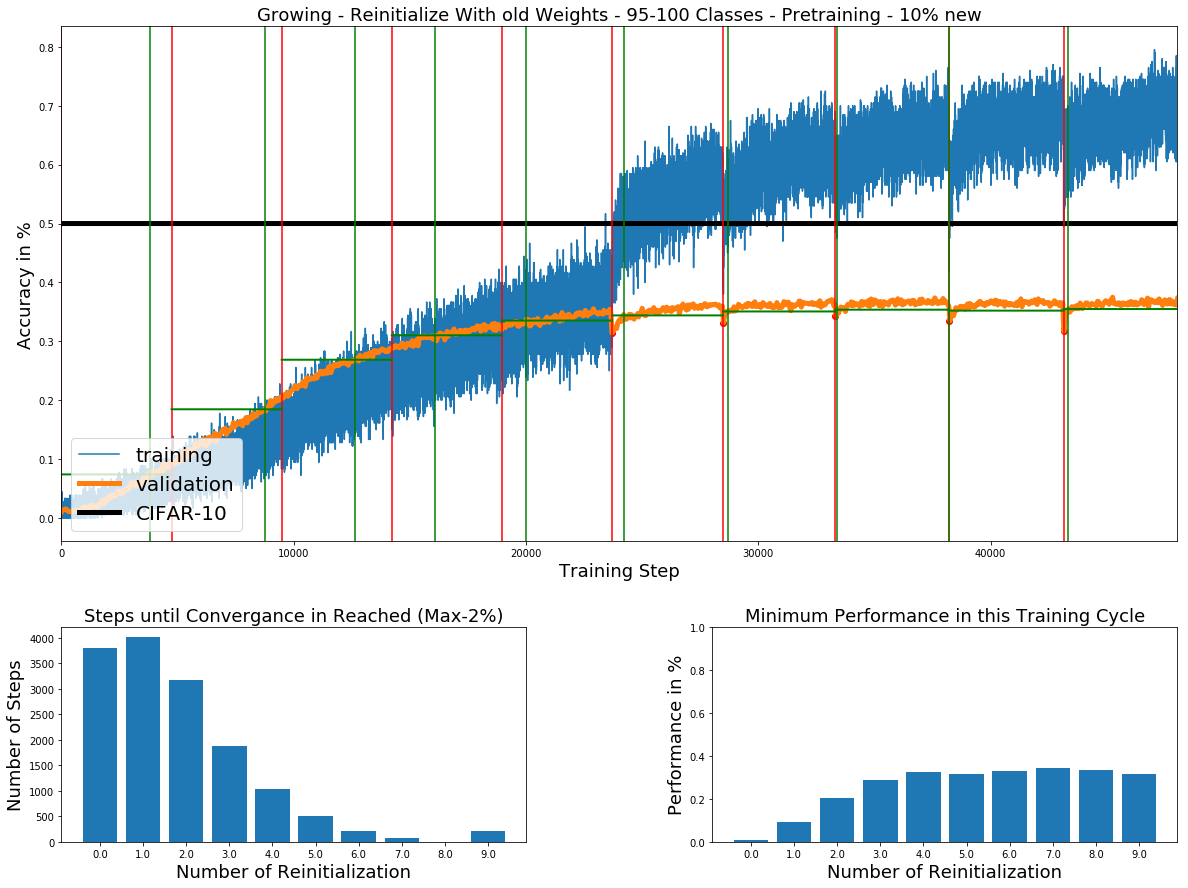

In [218]:
plotPerformance(training_accuracies,validation_accuracies_P,ESteps,"Growing - Reinitialize With old Weights - 95-100 Classes - Pretraining - 10% new",useVal=True)
#plt.savefig('Results/CIFAR100-95-100C-Grow-Augment-PreTrain-10%new.png')

### Comparison Between Performance on Old and New Classes

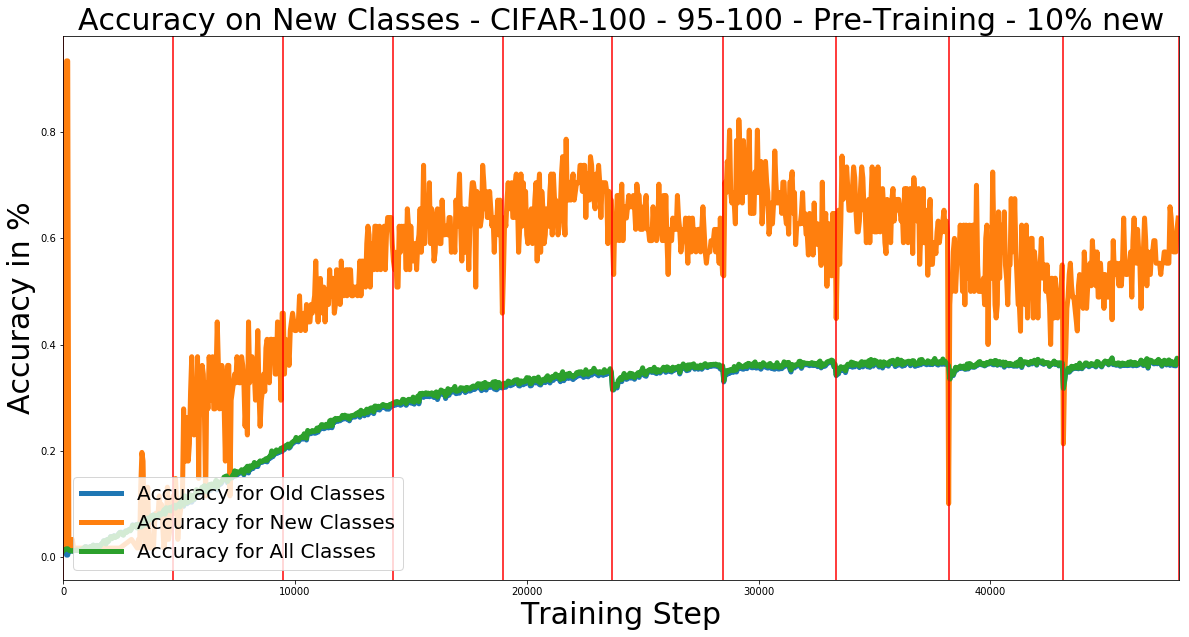

In [219]:
plt.figure(figsize=(20,10))
plt.plot(np.nonzero(val_accuracies_old)[0],val_accuracies_old[np.nonzero(val_accuracies_old)],linewidth=5)
plt.plot(np.nonzero(val_accuracies_new)[0],val_accuracies_new[np.nonzero(val_accuracies_new)],linewidth=5)
plt.plot(np.nonzero(validation_accuracies_P)[0],validation_accuracies_P[np.nonzero(validation_accuracies_P)],linewidth=5)
#plt.plot(validation_accuracies,linewidth=5)
#plt.plot(np.full(850,0.98), linewidth=5, color = 'black')
plt.xlabel("Training Step", fontsize=30)
plt.ylabel("Accuracy in %", fontsize=30)
plt.title("Accuracy on New Classes - CIFAR-100 - 95-100 - Pre-Training - 10% new", fontsize=30)
plt.xlim(0,ESteps[-1])
plt.legend(['Accuracy for Old Classes','Accuracy for New Classes','Accuracy for All Classes','Baseline Model'],fontsize=20,loc=3)
for e in ESteps:
    plt.axvline(x=e,color='r')
#plt.savefig('Results/CIFAR100_95-100_NewOld_PreTrain_10%new.png')

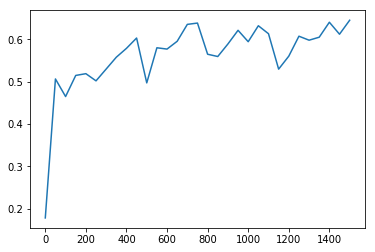

In [73]:
plt.plot(np.nonzero(validation_accuracies_P[:1600])[0],validation_accuracies_P[np.nonzero(validation_accuracies_P[:1600])])

### Performance Without Growing

In [16]:
epochs = 10
newClasses = 10
numC=100

mini_batch_size = 200
plot_step_size = 50
training_steps = cifar.get_sizes()[0] // mini_batch_size

training_cross_entropies = np.zeros(training_steps * epochs * newClasses)
validation_cross_entropies = np.zeros(training_steps * epochs * newClasses)

training_accuracies = np.zeros(training_steps * epochs * newClasses)
validation_accuracies = np.zeros(training_steps * epochs * newClasses)

ESteps = [0]
#weightName = 'LastLayer/weights_46/op_0:0'
weightName = 'LastLayer/weights_4100:0'
outName = 'LastLayer/add:0'
n=1
with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())
    step = 0
    for nC in range(newClasses):             
        last_step = False
        s = 0
        for epoch in range(epochs):
            for images, labels in cifar.get_training_batch(mini_batch_size,numC-1):
                images = augment(images)
                if s == 0:
                    print(labels.shape)
                    training_cross_entropies[step], training_accuracies[step],FirstOut,Firstweights,Firstgrad = session.run(
                    [cross_entropy, accuracy, outLog,weightName,gradient],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                    FirstL = labels
                s = s+1
                training_cross_entropies[step], training_accuracies[step], _ = session.run(
                    [cross_entropy, accuracy, training_step],feed_dict ={x: images, desired: labels,keep_prob:0.7}
                )
                                
                
                if step == (training_steps * epochs)-1:
                    last_step = True

                if step % plot_step_size == 0 or last_step:
                    images, vlabels = next(cifar.get_validation_batch(0,numC-1))
                    
                    validation_cross_entropy, validation_accuracy,out,weights,grad= session.run(
                        [cross_entropy, accuracy,outLog,weightName,gradient],
                        feed_dict = {x: images, desired: vlabels,keep_prob:1.0}
                    )
                    
                    if step != 0:
                        on = step - plot_step_size if not last_step else step - plot_step_size + 1
                        off = on + plot_step_size
                        validation_cross_entropies[on:off] = [validation_cross_entropy] * plot_step_size
                        validation_accuracies[on:off] = [validation_accuracy] * plot_step_size

                    #print("Training: " , training_accuracies[step] , "validation: " , validation_accuracy, "numClasses: ", numC, " outlayersize: ",str(numOutP))
                step += 1
        #numC = numC+10
        #numOutP = numOutP +1
        #print(weights)
        #print("old: "+str(weights))
        print(weights.shape)
        #ax = fig.add_subplot(7, 1, n)
        #plotViolinWeightsAx(weights,"End Weights for each Output Node - Old Weight Init, Zero Start")
        #plotWeights(weights,512,weights.shape[1])
        """print(FirstOut[1])
        ax = fig.add_subplot(2, 6, n)
        plt.imshow(FirstOut[1].reshape((numC-1,1)))
        ax.set_title("target: "+str(FirstL[1]))
        plt.colorbar()
        ax = fig.add_subplot(2, 6, n+1)
        plt.imshow(softmax(FirstOut[1]).reshape((numC-1,1)),vmin=-1,vmax=1)
        ax.set_title("target: "+str(FirstL[1]))
        plt.colorbar()
        n = n+2"""
        ESteps = np.append(ESteps,step)
        n=n+1


(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)
(200,)
(512, 100)


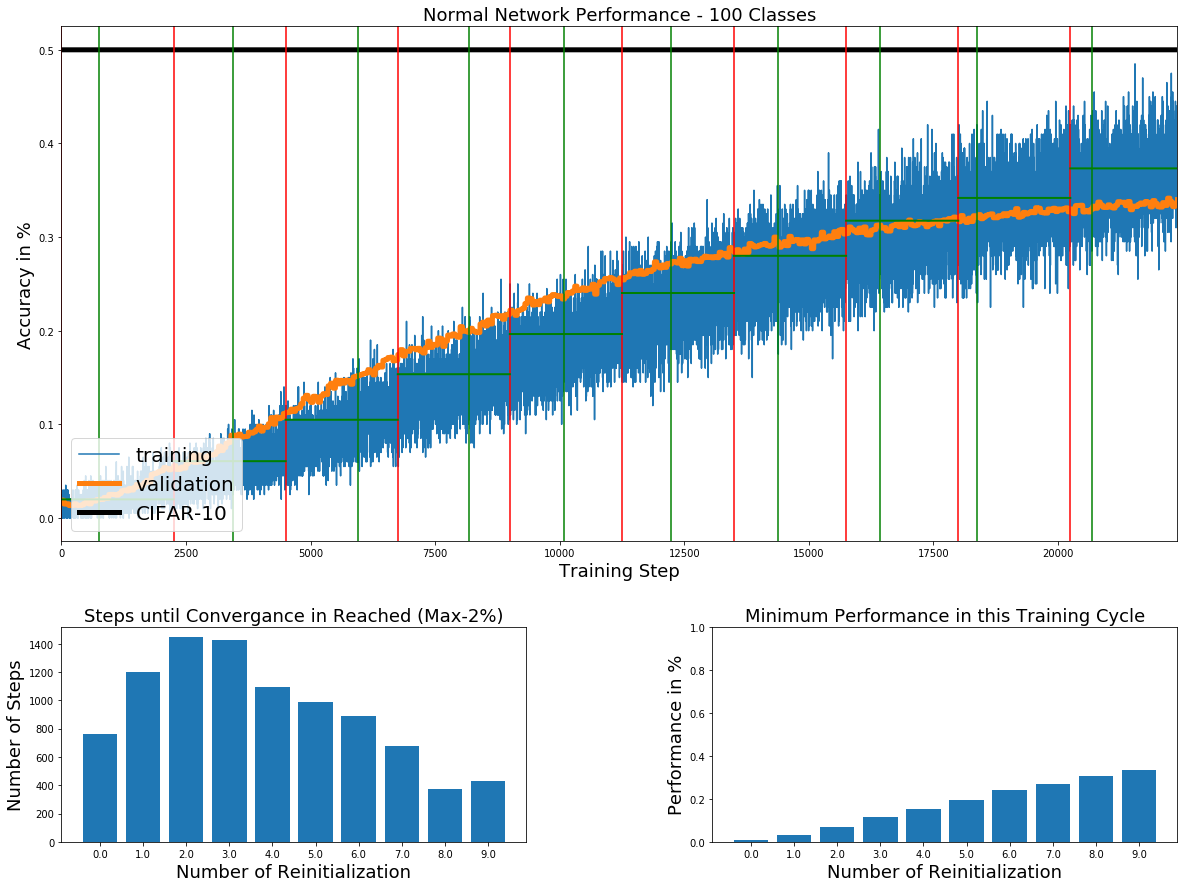

In [17]:
plotPerformance(training_accuracies,validation_accuracies,ESteps,"Normal Network Performance - 100 Classes")
#plt.savefig('Results/CIFAR100-Perf-Aug.png')